### Discontinuous Galerkin code for a linear base equation

Solves

$$
\frac{\partial u}{\partial t} + 2 \pi \frac{\partial u}{\partial x} = 0,
$$
$$
x \in [L, R]
$$
$$
u(x,0) = \sin(x),
$$
$$
u(L,t) = 2\pi\sin(L - 2\pi t)
$$

with a discontinuous Galerkin scheme based on [Hesthaven & Warburton](https://link.springer.com/book/10.1007%2F978-0-387-72067-8) chapter 3.

In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sp
import numpy.linalg as la
import scipy
import time

class Face1D:
    
    def __init__(self, x):
        """
        Initialize a face at physical location x
        """
        self.x = x
        self.f = 0.0
        self.left = None
        self.right = None
    
    def flux(self, t, alpha = 1.0):
        """
        Calculate numerical flux
        """
        if not self.left:
            return 2.0*np.pi*np.sin(self.x - 2.0*np.pi*t)
        elif not self.right:
            return 2.0*np.pi*self.left.u[-1]
        else:
            um = self.left.u[-1]
            up = self.right.u[0]
            return 2.0*np.pi*(0.5*(um + up) + 0.5*(1.0 - alpha)*(um - up))
            

class Cell1D:
    
    def __init__(self, N, xl, xr):
        """
        Initialize a cell with N nodes between xl and xr
        """
        self.N = N
        self.u = np.zeros((N,))
        self.xl = xl
        self.xr = xr
        self.h = xr - xl
        self.M = Cell1D.mass(N)
        self.D = Cell1D.differentiation(N)
        self.L = Cell1D.lift(N)
        self.left = None
        self.right = None
      
    def get_x(self):
        """
        Get physical location of nodes
        """
        r = Cell1D.lgl_points(self.N)
        return self.xl + 0.5*(r + 1.0)*(self.xr - self.xl)
    
    def set_u(self, u):
        """
        Set node values
        """
        self.u = u(self.get_x()) 
    
    def basis_coeff(N):
        """
        Return coefficients for order-N basis functions
        """
        return sp.legendre(N-1) / np.sqrt(2.0 / (2.0 * (N-1) + 1))

    def lgl_points(N):
        """
        Compute and return N Legendre-Gauss-Lobatto points
        """
        poly = np.poly1d([-1.0, 0.0, 1.0]) * Cell1D.basis_coeff(N).deriv()
        return np.sort(np.roots(poly))
    
    def vandermonde(N):
        """
        Calculate N-point Vandermonde matrix
        """
        V = np.zeros((N,N))
        r = Cell1D.lgl_points(N)
        for j in range(N):
            p = Cell1D.basis_coeff(j+1)
            V[:,j] = np.polyval(p, r)
        return V
    
    def mass(N):
        """
        Calculate order-N mass matrix
        """
        v = Cell1D.vandermonde(N)
        return la.inv(np.matmul(v, v.transpose()))
    
    def differentiation(N):
        """
        Calculate N-point differentiation matrix
        """
        P = np.zeros((N,N))
        r = Cell1D.lgl_points(N)
        for i in range(N):
            p = Cell1D.basis_coeff(i+1)
            P[i,:] = np.polyval(p.deriv(), r)
        V = Cell1D.vandermonde(N)
        return np.matmul(P.transpose(), la.inv(V))
    
    def lift(N):
        """
        Return lifting operator for fluxes at boundaries
        """
        m = Cell1D.mass(N)
        e = np.zeros((N, 2))
        e[0,0] = -1.0
        e[-1,1] = 1.0
        return np.matmul(la.inv(m), e)
        
class DG1D:
    
    def __init__(self, N, K, L, R):
        """
        Initialize a model with K cells evenly distributed between L and R with N nodes per cell
        """
        self.cells = []
        self.K = K
        self.N = N
        self.faces = []
        X = np.linspace(L, R, K+1)
        self.t = 0.0
        
        # Initialize at leftmost cell
        k = 0
        c = Cell1D(N, X[k], X[k+1])
        f1 = Face1D(X[k])
        f2 = Face1D(X[k+1])
        c.left = f1
        c.right = f2
        f1.right = c
        f2.left = c
        self.cells.append(c)
        self.faces.append(f1)
        self.faces.append(f2)
        
        # Other cells
        for k in range(1,K):
            c = Cell1D(N, X[k], X[k+1])
            f = Face1D(X[k+1])
            self.faces[-1].right = c
            c.left = self.faces[-1]
            c.right = f
            f.left = c
            self.cells.append(c)
            self.faces.append(f)
        
        # Set initial values
        for c in self.cells:
            c.set_u(lambda x: np.sin(x))
            
    def rhs(self, t):
        """
        Calculate RHS terms
        """
        G = self.K * [np.zeros((self.N,))]
        f = np.zeros((2,))
        for k, c in enumerate(self.cells):
            f[0] = 2.0*np.pi*c.u[0] - c.left.flux(t)
            f[1] = 2.0*np.pi*c.u[-1] - c.right.flux(t)
            G[k] = -4.0*np.pi/c.h * np.matmul(c.D, c.u) + 2.0/c.h * np.matmul(c.L, f)
        return G
    
    def step(self, deltat):
        """
        Low-storage RK4 timestepper: advance u from time t to time t + deltat
        based on the tendency given by rhs(u, t)
        """
        rk4a = np.array([ 0.0,
        -567301805773.0/1357537059087.0,
        -2404267990393.0/2016746695238.0,
        -3550918686646.0/2091501179385.0,
        -1275806237668.0/842570457699.0]);
        rk4b = np.array([ 1432997174477.0/9575080441755.0,
        5161836677717.0/13612068292357.0,
        1720146321549.0/2090206949498.0,
        3134564353537.0/4481467310338.0,
        2277821191437.0/14882151754819.0]);
        rk4c = np.array([ 0.0,
        1432997174477.0/9575080441755.0,
        2526269341429.0/6820363962896.0,
        2006345519317.0/3224310063776.0,
        2802321613138.0/2924317926251.0]);

        aux = self.K * [np.zeros((self.N,))]
        for i in range(5):
            G = self.rhs(self.t + rk4c[i]*deltat)
            for k, c in enumerate(self.cells):
                aux[k] = rk4a[i]*aux[k] + deltat * G[k]
                c.u = c.u + rk4b[i]*aux[k]
        self.t += deltat
        
    def get_state(self):
        """
        Get model state
        """
        x = np.array([c.get_x() for c in self.cells]).ravel()
        u = np.array([c.u for c in self.cells]).ravel()
        return (x, u)
    
    def get_reference_state(self):
        """
        Get exact solution at model nodes
        """
        x = np.array([c.get_x() for c in self.cells]).ravel()
        u = np.sin(x - 2*np.pi*self.t)
        return (x, u)

In [3]:
K = 10
N = 5
L = 0
R = 2.0*np.pi
model = DG1D(N, K, L, R)

<IPython.core.display.Javascript object>


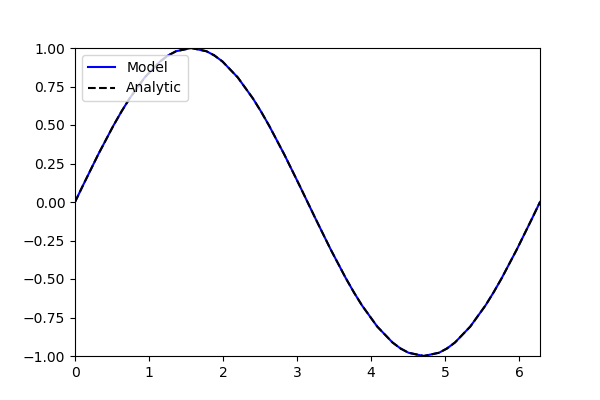

(0, 6.283185307179586)

In [4]:
x, u = model.get_state()
xr, ur = model.get_reference_state()
fig = plt.figure(figsize = (6, 4), dpi = 100)
ax = fig.gca()
ax.plot(x, u, 'b')
ax.plot(xr, ur, 'k--')
ax.legend(['Model', 'Analytic'], loc = 'upper left')
ax.set_ylim([-1, 1])
ax.set_xlim([L, R])

In [5]:
for _ in range(1000):
    model.step(0.01)
    x, u = model.get_state()
    xr, ur = model.get_reference_state()
    ax.lines[0].set_ydata(u)
    ax.lines[1].set_ydata(ur)
    fig.canvas.draw()

#### Some extra plots related to DG operators
Compare with figures 3.2 and 3.5 in Hesthaven and Warburton

<IPython.core.display.Javascript object>


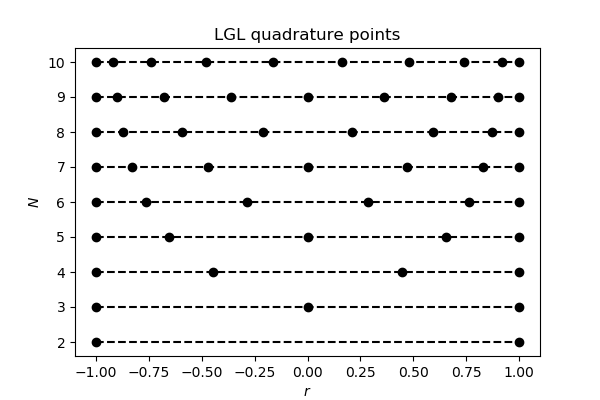

Text(0.5, 1.0, 'LGL quadrature points')

In [6]:
plt.figure(figsize = (6, 4), dpi = 100)
for i in range(2, 11):
    plt.plot(Cell1D.lgl_points(i), i * np.ones(Cell1D.lgl_points(i).shape), 'ko--')
plt.ylabel('$N$')
plt.xlabel('$r$')
plt.title('LGL quadrature points')

<IPython.core.display.Javascript object>


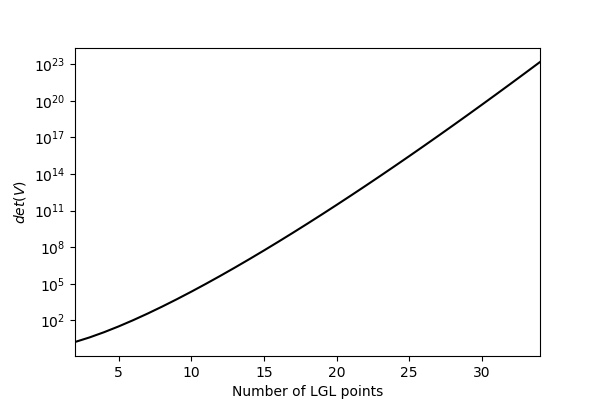

(2, 34)

In [7]:
N = np.arange(2, 35)
det = np.array([np.linalg.det(Cell1D.vandermonde(nn)) for nn in N])
plt.figure(figsize = (6, 4), dpi = 100)
plt.plot(N, det, 'k')
plt.gca().set_yscale('log')
plt.xlabel('Number of LGL points')
plt.ylabel('$det(V)$')
plt.xlim([2, 34])

<IPython.core.display.Javascript object>


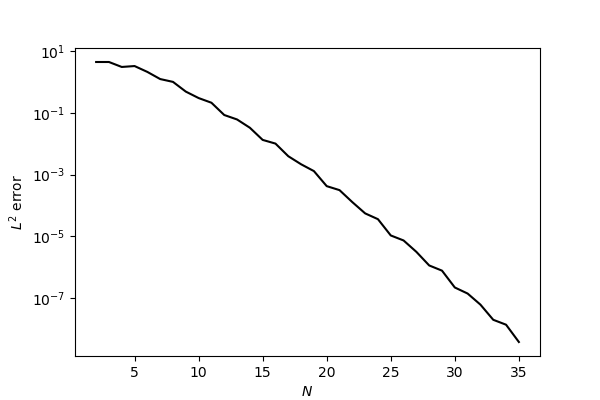

Text(0, 0.5, '$L^2$ error')

In [8]:
N = np.arange(2,36)
err = np.zeros(N.shape)
for ii, n in enumerate(N):
    x_i = Cell1D.lgl_points(n)
    u_i = np.exp(np.sin(np.pi*x_i))
    D = Cell1D.differentiation(n)
    dxu_i = np.matmul(D, u_i)
    dxu = np.pi * np.cos(np.pi*x_i) * np.exp(np.sin(np.pi*x_i))
    err[ii] = np.sqrt(np.trapz((dxu_i - dxu)**2.0, x = x_i))
plt.figure(figsize = (6, 4), dpi = 100)
plt.plot(N, err, 'k')
plt.gca().set_yscale('log')
plt.xlabel('$N$')
plt.ylabel('$L^2$ error')